# 图像特征提取

## 最简单的图像特征
如果使用像素作为特征 有两种方法

一个是使用统计量 统计RGB的分布 这样会出现分布类似但是完全不同的情况

另一个是使用像素值的差异 如欧氏距离等 但是这样进行模式识别时 物体位置的移动 旋转就会破坏距离

因此 像素不能携带图像足够多的语义信息 它并不是合适的特征提取方式

## 人工特征提取
### SIFT 尺度不变特征转换 Scale Invariant Feature Transform
SIFT最初是对对象识别任务开发 不仅要正确地标注出图像中包含某种对象 还要确定对象在图像中的位置

### 图像梯度
要想比原始像素值提取特征更好 就需要将像素组织成信息量更大的单位

相邻像素之间的差别通常是非常有用的 像素值一般在对象的边界发生改变 如阴影 模式 或 纹理上

**相邻像素在值上的差异称为图像梯度**

像素(i,j)的x梯度和y梯度分别是：

gx(i,j) = -1 * I(i-1,j) + 1 * I(i+1,j)

gy(i,j) = -1 * I(i,j-1) + 1 * I(i,j+1)

其中*是卷积操作 I是像素值

这样就构成了梯度 [gx(i,j), gy(i,j)]

梯度大小等于欧氏距离 方向等于arctan(gy/gx)


In [ ]:
# 计算图像梯度

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import data, color

In [2]:
data.chelsea()

array([[[143, 120, 104],
        [143, 120, 104],
        [141, 118, 102],
        ...,
        [ 45,  27,  13],
        [ 45,  27,  13],
        [ 45,  27,  13]],

       [[146, 123, 107],
        [145, 122, 106],
        [143, 120, 104],
        ...,
        [ 46,  29,  13],
        [ 45,  29,  13],
        [ 47,  30,  14]],

       [[148, 126, 112],
        [147, 125, 111],
        [146, 122, 109],
        ...,
        [ 48,  28,  17],
        [ 49,  29,  18],
        [ 50,  30,  19]],

       ...,

       [[ 92,  58,  30],
        [105,  71,  43],
        [132,  98,  71],
        ...,
        [172, 145, 138],
        [172, 145, 138],
        [172, 145, 138]],

       [[128,  92,  60],
        [139, 103,  71],
        [134,  95,  64],
        ...,
        [166, 142, 132],
        [166, 142, 132],
        [167, 143, 133]],

       [[139, 103,  71],
        [127,  88,  57],
        [125,  86,  53],
        ...,
        [161, 137, 127],
        [161, 137, 127],
        [162, 138, 128]]

In [4]:
# 加载图像 并从rgb转为灰度模式
img = color.rgb2gray(data.chelsea())
img

array([[0.48523098, 0.48523098, 0.47738784, ..., 0.11692392, 0.11692392,
        0.11692392],
       [0.49699569, 0.49307412, 0.48523098, ..., 0.12336824, 0.1225349 ,
        0.1272898 ],
       [0.50849255, 0.50457098, 0.49475569, ..., 0.12336039, 0.12728196,
        0.13120353],
       ...,
       [0.24786745, 0.29884784, 0.40501294, ..., 0.58914824, 0.58914824,
        0.58914824],
       [0.38173647, 0.42487373, 0.39628392, ..., 0.57403529, 0.57403529,
        0.57795686],
       [0.42487373, 0.36883294, 0.36042431, ..., 0.55442745, 0.55442745,
        0.55834902]])

In [5]:
gx = np.empty(img.shape, dtype=np.double)
gx[:,0] = 0
gx[:,-1] = 0
# 初始化两侧为0
gx[:, 1:-1] = img[:,:-2] - img[:,2:]
# 水平方向梯度等于它左边的像素减去它右边的

gy = np.empty(img.shape, dtype=np.double)
gy[0,:] = 0
gy[-1,:] = 0
# 初始化最上和最下为0
gy[1:-1,:] = img[:-2,:] - img[2:,:]
# 垂直方向梯度等于它上边减去它下面的像素

In [10]:
img.shape

(300, 451)

In [9]:
gx.shape

(300, 451)

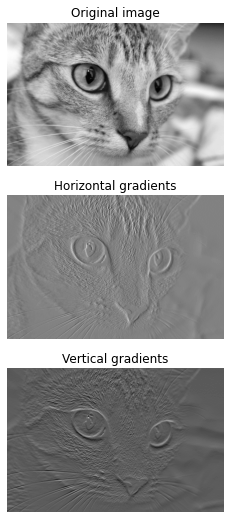

In [11]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(5,9),sharex=True,sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Original image')
ax1.set_adjustable('box')

ax2.axis('off')
ax2.imshow(gx,cmap=plt.cm.gray)
ax2.set_title('Horizontal gradients')
ax2.set_adjustable('box')

ax3.axis('off')
ax3.imshow(gy,cmap=plt.cm.gray)
ax3.set_title('Vertical gradients')
ax3.set_adjustable('box')

# 水平梯度保留了明显的垂直方向的特征 比如猫的眼睛 鼻子
# 垂直梯度保留了明显的水平方向的特征 比如猫的胡须等

# 梯度方向的直方图

SIFT和HOG都是计算梯度向量的直方图作为图像特征

直方图将数据分装到多个箱子中 并计算出每个箱子中数据点的数量 是一种经验分布

实践方法是：按照图像梯度的方向角 进行分箱 按照每个梯度的大小进行加权

具体方法是：
1. 将0-360°进行等宽分箱
2. 对于邻域中的每个像素 在与其方向角对应的分箱中添加一个权重w w是该像素梯度大小与其他信息的一个函数
比如可以是像素到小块中心距离的倒数 直觉上理解是梯度大 权重应该大 而且靠近图像邻域中心的像素重要程度更高
3. 对直方图归一化

## 分箱策略
更多的分箱可以对梯度方向进行粒度更细的量化 可以保留更多信息

但是过多的分箱则会造成过拟合 如每1°一个分箱的话 严格要求3°是猫的胡须是不合理的

## 权重函数
梯度大小的加权方式：向量本身的长度、长度的平方或平方根、二值化、裁剪等

效果都是通过实验得到的 向量本身的长度似乎从实验效果来看更好一些

## 邻域确定方法
定义邻域的方法：首先将相邻的像素组成单元 然后再将邻近的单元组成块

不管邻域的组织模式如何 通常通过重叠来形成整个图像的特征向量 单元和块沿着两个方向平移 但是每次仅移动几个像素
目的是要覆盖整个图像 这种思想在深度神经网络中也用到

## 归一化方法
归一化使得特征描述变得均衡 并且大小可以比较

图像的归一化很有效果 例如考虑同样的苹果图像 一个位于强光源下 一个位于柔和的光源下
这两个苹果对象相同 但是梯度大小差别非常大 如果能够对颜色归一化 就可以消除照明和对比度产生的差异

有归一化-阈值-归一化方法：首先归一化到l2范数 然后裁剪大于最大值的数(消除极端的照明效果)最后再次归一化



# SIFT体系
1. 从原始像素的感兴趣区域开始 将该区域划分为网格
2. 将网格单元进一步划分为子网格
3. 每个子网格的元素都生成一个加权梯度估计
4. 梯度估计被聚合为方向直方图 子网格的直方图被连接成为整个网络的直方图
5. 归一化-阈值裁剪-归一化过程

![SIFT](./SIFT.png)